In [136]:
import os
import pandas as pd
import nltk
from nltk import FreqDist

path = os.getcwd()

print(path)
path="C:/Users/Krishna/Desktop/IST 664 NLP"
os.chdir(path)
print(path)

C:\Users\Krishna\Desktop\IST 664 NLP
C:/Users/Krishna/Desktop/IST 664 NLP


In [137]:
df=pd.read_excel(path+'/projectdata.xlsx', index_col=None)

In [138]:
df_with_external_sources=df[['Submission']].loc[df['externalSource'] == 1].reset_index() #PREVIOUSLU FLAGGED SUBMISSIONS
df_with_external_sources.head()

,index,Submission
0,5,I was reading this article from the NYT [How T...
1,11,Well... This has been on my chest for a long t...
2,13,I've mostly seen people say the gaming communi...
3,17,I saw this a while back about California and t...
4,24,The 1st Amendment to the US Constitution (Bill...


In [139]:
df['externalSource'].value_counts()

0    239
1     91
Name: externalSource, dtype: int64

In [140]:
from nltk.tokenize import PunktSentenceTokenizer
custom_sent_tokenizer = PunktSentenceTokenizer(str())
tokenized=[]
for i in df['Submission'] :
    #tokenized.append(str(i))
    custom_sent_tokenizer = PunktSentenceTokenizer(str(i))
    tokenized.append(custom_sent_tokenizer.tokenize(str(i)))

last 11 scentences of most submission is junk :


In [141]:
repeating_pattern=tokenized[5][-11:]
repeating_pattern

['_____\n\n&gt; *Hello, users of CMV!',
 'This is a footnote from your moderators.',
 "We'd just like to remind you of a couple of things.",
 'Firstly, please remember to* ***[read through our rules](http://www.reddit.com/r/changemyview/wiki/rules)***.',
 '*If you see a comment that has broken one, it is more effective to report it than downvote it.',
 "Speaking of which,* ***[downvotes don't change views](http://www.reddit.com/r/changemyview/wiki/guidelines#wiki_upvoting.2Fdownvoting)****!",
 'If you are thinking about submitting a CMV yourself, please have a look through our* ***[popular topics wiki](http://www.reddit.com/r/changemyview/wiki/populartopics)*** *first.',
 'Any questions or concerns?',
 'Feel free to* ***[message us](http://www.reddit.com/message/compose?to=/r/changemyview)***.',
 '*Happy CMVing!',
 '*']

In [142]:
pattern_list = ['_____\n\n&gt; *Hello, users of CMV!', 'This is a footnote from your moderators.', "We'd just like to remind you of a couple of things.", 'Firstly, please remember to* ***[read through our rules](http://www.reddit.com/r/changemyview/wiki/rules)***.', '*If you see a comment that has broken one, it is more effective to report it than downvote it.', "Speaking of which,* ***[downvotes don't change views](http://www.reddit.com/r/changemyview/wiki/guidelines#wiki_upvoting.2Fdownvoting)****!", 'If you are thinking about submitting a CMV yourself, please have a look through our* ***[popular topics wiki](http://www.reddit.com/r/changemyview/wiki/populartopics)*** *first.', 'Any questions or concerns?', 'Feel free to* ***[message us](http://www.reddit.com/message/compose?to=/r/changemyview)***.', '*Happy CMVing!', '*']
cleaned_tokenized=[]
for i in range(0,len(tokenized)):
    for j in pattern_list:
            if j in tokenized[i]:
                flag=1
    if (len(tokenized[i])>11):                
        if flag ==1 :
            cleaned_tokenized.append(tokenized[i][:-11])
        else:
            cleaned_tokenized.append(tokenized[i])
    else:
        cleaned_tokenized.append(tokenized[i])
        

In [143]:
import re 

def Find(string): 
    # findall() has been used  
    # with valid conditions for urls in string 
    url = re.findall('[(]http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\), ][)]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', string)
    return url 

    
# Driver Code 
#
cleaned_tokenized_withURL=[]
index1=[]
for i in range(0,len(cleaned_tokenized)):
    pattern=Find(str(cleaned_tokenized[i]))
    if len(pattern)>0:
        cleaned_tokenized_withURL.append(cleaned_tokenized[i])
        index1.append(i)

In [144]:
def bracketed_find(s, start, end, startat=2):
    """
    Function to find content in between two words or characters without regex.
    From http://stackoverflow.com/questions/1116172/finding-content-between-two-words-withou-regex-beautifulsoup-lxml-etc
    """
    startloc=s.find(start, startat)
    if startloc==-1:
        return []
    endloc=s.find(end, startloc+1+len(start))
    if endloc == -1:
        return [s[startloc+len(start):]]
    return [s[startloc+len(start):endloc]] + bracketed_find(s, start, end, endloc+len(end))

def num_words_between_quotes(words):
    '''
    Uses the helper functions above to count the number of words in the input
    text that fall between quote marks. Returns that number rounded to the nearest
    5 words, again to make the continuous data more categorical.
    '''
    num_words_between_quotes = 0
    lots_of_words_between_quotes = False
    for q in bracketed_find(words, '"', '"'):
        num_words_between_quotes += len(q.split())
    return round(num_words_between_quotes, -1) / 2

In [145]:
PUNCTUATION_TO_REMOVE = ['.', ',', '!', '?']
ATTRIBUTION_WORDS_STEMMED = ['said', 'say', 'call', 'accus', 'tell', 'told', 'report','sources','assur']
PRONOUNS = ['he', 'she']
from nltk.stem import PorterStemmer

def clean_text(words):
    """
    Function to clean input text by removing select punctuation and stopwords
    and stemming with a Porter stemmer.
    """
    for p in PUNCTUATION_TO_REMOVE:
        words = words.replace(p, '')
    stopwords = nltk.corpus.stopwords.words('english')
    return ' '.join([PorterStemmer().stem(w) for w in words.split() if w not in stopwords])

def said_near_source(words):
    '''
    Janky set of regexes that return true if the word said appears within five words
    of a pronoun or capitalized (proper) noun. This should be rewritten for about a
    million different reasons, but it works fine for demo purposes, so ....
    '''
    words = clean_text(words)
    said_near_source = 0
    if len(re.findall(r'\b(he|people|journals|friends|she|it|they|[A-Z][a-z]+)$(?!.*being|.*having|).*$\W+(?:\w+\W+){0,10}(said|say|say things|often say|call|accus|tell|told|report|sources|assur|added|says)\b', words)) > 0 \
        or len(re.findall(r'\b(said|say|call|accus|tell|told|report|sources|assur|added|says){0,10}(he|it|they|she|[A-Z][a-z]+)\W+(?:\w+\W+)\b', words)) > 0:
        said_near_source = 1
    return said_near_source


In [146]:
from nltk.corpus import wordnet

def get_wordnet_pos(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
from nltk import pos_tag
import string
from nltk.corpus import stopwords
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer

def clean_text2(text):
    # lower text
    text = text.lower()
    # tokenize text and remove puncutation
    text = [word.strip(string.punctuation) for word in text.split(" ")]
    # remove words that contain numbers
    text = [word for word in text if not any(c.isdigit() for c in word)]
    # remove stop words
    stop = stopwords.words('english')
    text = [x for x in text if x not in stop]
    # remove empty tokens
    text = [t for t in text if len(t) > 0]
    # pos tag text
    pos_tags = pos_tag(text)
    # lemmatize text
    text = [WordNetLemmatizer().lemmatize(t[0], get_wordnet_pos(t[1])) for t in pos_tags]
    # remove words with only one letter
    text = [t for t in text if len(t) > 1]
    # join all
    text = " ".join(text)
    return(text)

Text(0.5, 1.0, 'Y variable Distribution \n (0: Negative || 1: Positive)')

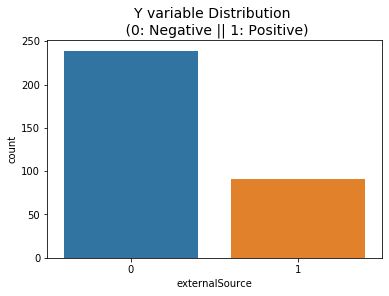

In [158]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.countplot('externalSource', data=df)
plt.title('Y variable Distribution \n (0: Negative || 1: Positive)', fontsize=14)

In [163]:
# Divide by class

new_data = df.sample(frac=1)
neg_df = new_data.loc[new_data['externalSource'] == 1]
pos_df = new_data.loc[new_data['externalSource'] == 0][:len(neg_df)]
normal_distributed_df = pd.concat([pos_df, neg_df])
# Picking Normally Distributed Curves
new_data = normal_distributed_df.sample(frac=1, random_state=42)
new_data.shape

(182, 12)

Text(0.5, 1.0, ' Distribution Distributions \n (0: No Fraud || 1: Fraud)')

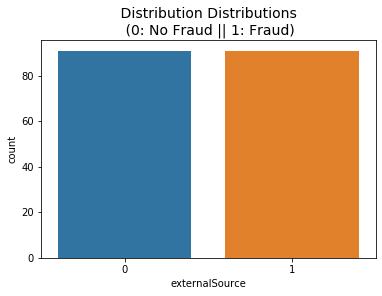

In [165]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.countplot('externalSource', data=new_data)
plt.title(' Distribution Distributions \n (0: No Fraud || 1: Fraud)', fontsize=14)

In [166]:
df=new_data.reset_index()

In [167]:
df['Sent_tokens']=0
for i in range(0,len(df)):
    df['Sent_tokens'][i]=clean_text2(''.join(cleaned_tokenized[i]))

E:\Py\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
E:\Py\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [168]:
df.head()

,index,Topic,Title,Submission,Rationale,Claim,PE,DomainExpertise,externalSource,Definition,Atleast2,Atleast1,Submission_1,Sent_tokens
0,240,Everyday,It should not be a considered rude if someone ...,"From a sociological perspective, the idea of a...",1,1,1,0,0,0,0,1,"From a sociological perspective, the idea of a...",true eventually leave traditional education es...
1,15,DP,The US founding fathers were hypocrites and th...,"The Founding Fathers were all wealthy, educate...",1,1,0,0,0,0,0,0,"The Founding Fathers were all wealthy, educate...",really never see point search world peace unif...
2,266,Everyday,"CMV: Having a ""traditional"" bridal party (defi...","**Definitions &amp; Background:** \n\nA ""tradi...",1,1,0,0,1,1,1,1,"**Definitions &amp; Background:** \n\nA ""tradi...",state provide easy painless method suicide exa...
3,133,DP,Democracy is an inept system of government.,I would like to start by saying that I fully b...,1,1,0,0,1,1,1,1,I would like to start by saying that I fully b...,equal ultimately opinion considers knowledge i...
4,219,Education,I believe that standardized tests such as the ...,The goals of the ACT/SAT tests are to measure ...,1,1,0,0,1,0,0,1,The goals of the ACT/SAT tests are to measure ...,every always seem find mattel disney fire real...


In [170]:
import pickle
df['text_tokens']=1
df['text_tokens'] = df.apply(lambda row: nltk.word_tokenize(str(row['Sent_tokens'])), axis=1)
with open('df1.pkl', 'wb') as f:
    pickle.dump(df, f)

In [171]:
documents=[]
for i in range(0,len(df)):
               documents.append((df['text_tokens'][i],df['externalSource'][i]))
   # documents=([(sent, cat) for cat in text_senti_df['Cat'] for sent in text_senti_df['text_tokens'] ])

In [172]:
documents = [x for x in documents if x[0]]

In [173]:
documents

[(['true',
   'eventually',
   'leave',
   'traditional',
   'education',
   'establishment',
   'maybe',
   'push',
   'couple',
   'year',
   'high',
   'education',
   'collage',
   'tech',
   'school',
   'etc',
   'feel',
   'many',
   'people',
   'feel',
   'end',
   'there.i',
   'always',
   'felt',
   'never',
   'end',
   'people',
   'learn',
   'anything',
   'everything',
   'feel',
   'compel',
   'push',
   'themselves.keeping',
   'limit',
   'learn',
   'time',
   'go',
   'normal',
   'school',
   'dumb',
   'overall',
   'ruin',
   'society',
   'achieve'],
  0),
 (['really',
   'never',
   'see',
   'point',
   'search',
   'world',
   'peace',
   'unify',
   'harmonious',
   'global',
   'population.it',
   'make',
   'sense',
   'me.this',
   'say',
   'i',
   "'m",
   'peaceful',
   '!',
   'i',
   'like',
   'fight',
   'like',
   'violence.i',
   'compassionate',
   'intellectual',
   'guy',
   'prefers',
   'debate',
   'understand',
   'side',
   'argument.b

In [174]:
import pickle
with open('documents2.pkl', 'wb') as f:
    pickle.dump(documents,f)

In [175]:
all_words_list = [word for (sent,cat) in documents for word in sent]
all_words = nltk.FreqDist(all_words_list)
word_items = all_words.most_common(50)
word_features = [word for (word,count) in word_items]
word_features[30]

'many'

In [176]:
def document_features(document, word_features):
    document_words = set(document)
    features = {}
    for word in word_features:
        features['contains({})'.format(word)] = (word in document_words)
    return features

In [177]:
featuresets = [(document_features(d, word_features), c) for (d, c) in documents]

In [178]:
train_set, test_set = featuresets[:120], featuresets[120:]
classifier = nltk.NaiveBayesClassifier.train(train_set)
nltk.classify.accuracy(classifier, test_set)

0.5483870967741935

In [179]:
from nltk.classify import SklearnClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import SVC
classif = SklearnClassifier(BernoulliNB()).train(train_set)
nltk.classify.accuracy(classif, test_set)

0.5483870967741935

In [180]:
pred_set=[]
for i in range(0,len(test_set)):
    pred_set.append(test_set[i][0])
out=[]
for i in pred_set:
    out.append(classifier.classify(i))

In [181]:
from sklearn.metrics import precision_score, recall_score,accuracy_score

def do_evaluation (pairs, pos_label=1, verbose=True):
    predicted, actual = zip(*pairs)
    (precision, recall,accuracy) = (precision_score(actual,predicted,pos_label=pos_label),
                                    recall_score(actual,predicted,pos_label=pos_label),
                                    accuracy_score(actual,predicted))
    if verbose:
        print_results(precision, recall, accuracy, pos_label)
    return (precision, recall,accuracy)

def print_results (precision, recall, accuracy, pos_label):
    banner =  'Evaluation with pos label = %s' % pos_label
    print (banner)
    print ('=' * len(banner))
    print( '{0:10s} {1:.1f}'.format('Precision',precision*100))
    print ('{0:10s} {1:.1f}'.format('Recall',recall*100))
    print ('{0:10s} {1:.1f}'.format('Accuracy',accuracy*100))

In [182]:
pairs = [(classifier.classify(example), actual)
            for (example, actual) in test_set]

do_evaluation (pairs)
pos_guesses = [p for (p,a) in pairs if p==1]
pos_actual = [a for (p,a) in pairs if a==1]
do_evaluation (pairs, pos_label=0)
print ('Note that {:.1%} of our classifier guesses were positive'.format(float(len(pos_guesses))/len(pairs)))
print ('While {:.1%} of the reviews were actually positive'.format(float(len(pos_actual))/len(pairs)))
# to see the actual pairs that came out of the test uncomment the next line
#pairs

Evaluation with pos label = 1
Precision  57.1
Recall     38.7
Accuracy   54.8
Evaluation with pos label = 0
Precision  53.7
Recall     71.0
Accuracy   54.8
Note that 33.9% of our classifier guesses were positive
While 50.0% of the reviews were actually positive


In [184]:
all_words_list = [i for j in df['Sent_tokens']  
       for i in zip(j.split(" ")[:-1], j.split(" ")[1:])] 
all_words = nltk.FreqDist(all_words_list)
biggramfreq = all_words.most_common(50)
word_features = [word for (word,count) in biggramfreq]
word_features[1]

('legacy', 'server')

In [185]:
featuresets2 = [(document_features(d, word_features), c) for (d, c) in documents]

In [186]:
featuresets2

[({"contains(('change', 'view'))": False,
   "contains(('legacy', 'server'))": False,
   "contains(('people', 'would'))": False,
   "contains(('many', 'people'))": False,
   "contains(('lot', 'people'))": False,
   "contains(('would', 'like'))": False,
   "contains(('white', 'privilege'))": False,
   "contains(('feel', 'like'))": False,
   'contains(("i\'m", \'go\'))': False,
   "contains(('people', 'like'))": False,
   "contains(('people', 'want'))": False,
   "contains(('private', 'server'))": False,
   "contains(('democratic', 'party'))": False,
   "contains(('people', 'get'))": False,
   "contains(('would', 'also'))": False,
   "contains(('seem', 'like'))": False,
   "contains(('catholic', 'church'))": False,
   "contains(('bad', 'thing'))": False,
   "contains(('war', 'bonnet'))": False,
   "contains(('death', 'penalty'))": False,
   "contains(('number', 'people'))": False,
   "contains(('try', 'get'))": False,
   "contains(('bernie', 'sander'))": False,
   "contains(('people', 'p

In [187]:
train_set, test_set = featuresets2[:120], featuresets2[120:]
classifier = nltk.NaiveBayesClassifier.train(train_set)
nltk.classify.accuracy(classifier, test_set)

0.5

In [188]:
len(train_set)

120

In [189]:
from nltk.classify import SklearnClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import SVC
classif = SklearnClassifier(BernoulliNB()).train(train_set)
nltk.classify.accuracy(classif, test_set)

0.5

In [190]:
from sklearn.metrics import precision_score, recall_score,accuracy_score

def do_evaluation (pairs, pos_label=1, verbose=True):
    predicted, actual = zip(*pairs)
    (precision, recall,accuracy) = (precision_score(actual,predicted,pos_label=pos_label),
                                    recall_score(actual,predicted,pos_label=pos_label),
                                    accuracy_score(actual,predicted))
    if verbose:
        print_results(precision, recall, accuracy, pos_label)
    return (precision, recall,accuracy)

def print_results (precision, recall, accuracy, pos_label):
    banner =  'Evaluation with pos label = %s' % pos_label
    print (banner)
    print ('=' * len(banner))
    print( '{0:10s} {1:.1f}'.format('Precision',precision*100))
    print ('{0:10s} {1:.1f}'.format('Recall',recall*100))
    print ('{0:10s} {1:.1f}'.format('Accuracy',accuracy*100))

In [196]:
pairs = [(classifier.classify(example), actual)
            for (example, actual) in test_set]

do_evaluation (pairs)
pos_guesses = [p for (p,a) in pairs if p==1]
pos_actual = [a for (p,a) in pairs if a==1]
do_evaluation (pairs, pos_label=0)
print ('Note that {:.1%} of our classifier guesses were positive'.format(float(len(pos_guesses))/len(pairs)))
print ('While {:.1%} of the reviews were actually positive'.format(float(len(pos_actual))/len(pairs)))
# to see the actual pairs that came out of the test uncomment the next line
#pairs

Evaluation with pos label = 1
Precision  50.0
Recall     100.0
Accuracy   50.0
Evaluation with pos label = 0
Precision  0.0
Recall     0.0
Accuracy   50.0
Note that 100.0% of our classifier guesses were positive
While 50.0% of the reviews were actually positive


In [60]:
classifier.show_most_informative_features(30)

Most Informative Features
 contains(("i'm", 'go')) = False               1 : 0      =      1.0 : 1.0
contains(("i've", 'see')) = False               1 : 0      =      1.0 : 1.0
contains(('much', 'less')) = False               1 : 0      =      1.0 : 1.0
contains(('year', 'ago')) = False               1 : 0      =      1.0 : 1.0
contains(('minimum', 'wage')) = False               1 : 0      =      1.0 : 1.0
contains(('group', 'people')) = False               1 : 0      =      1.0 : 1.0
contains(('number', 'people')) = False               1 : 0      =      1.0 : 1.0
contains(('year', 'old')) = False               1 : 0      =      1.0 : 1.0
contains(('climate', 'change')) = False               1 : 0      =      1.0 : 1.0
contains(('change', 'view')) = False               1 : 0      =      1.0 : 1.0
contains(('would', 'like')) = False               1 : 0      =      1.0 : 1.0
contains(('white', 'privilege')) = False               1 : 0      =      1.0 : 1.0
contains(('black', 'people')) =

In [197]:
def words_near_quotes(words):
    words = clean_text(words)
    if get_words_outside_quotes(words):
        for word in get_words_outside_quotes(words):
            yield word
    return word

def get_words_outside_quotes(words, n=10):
    """
    Function to get words within n characters of quote marks.
    """
    quote_indices = [m.start() for m in re.finditer(r'"([^"]*)"', words)]
    for i in range(len(quote_indices)):
        if i % 2 != 0:
            index = quote_indices[i] + 1
            try:
                next = quote_indices[i+1]
            except IndexError:
                next = len(words)
            return words[index:next].strip().split()[:10]


In [198]:


def first_quote_index(words):
    """
    Returns the index of the first quote mark in the input string. Rounds to
    the nearest 10th position. So a quote that appears at position 5 in a string
    will actually be output as 10 from this function.

    The reason is because NLTK's particular maxent classifier doesn't deal well 
    with continuous variables. Grouping them as every 10th position effectively
    makes the data categorical (the 10s, 20s, 30s, etc.)
    """
    return words.find('"')


In [199]:
def contains_quotes(words):
    """
    Returns true if the input string contains quote marks. Word of warning:
    be sure unicode smart quotes are swapped out for ascii dumb quotes or
    this won't catch them. Same goes for any other feature that looks for
    quotes.
    """
    contains_quotes = 0
    if words.find('"') > 2:
        contains_quotes = 1
    return contains_quotes
def get_features(words):
    '''
    Function that aggregates active features for the lm classifier and returns
    a feature dict in the format expected by scikit learn.
    '''
    features = {} # Start with empty feature dict

    # Put features here (found in classify.features)
    features['contains_quotes'] = contains_quotes(words)
    features['first_quote_index'] = first_quote_index(words)
    features['said_near_source'] = said_near_source(words)
    features['num_words_between_quotes'] = num_words_between_quotes(words)
#     for word in words_near_quotes(words):
#         features['%s_near_quote' % word] = 1

    return features

In [200]:
clean_full=[]
for i in range(0,len(withextsources)):
         clean_full.append(clean_text2(str(withextsources[i])))

In [201]:
len(clean_full)

216

In [202]:
def features(sentence):
    import re
    from statistics import mode 
    from collections import Counter
    c=Counter(sentence)
    """ sentence: [w1, w2, ...], index: the index of the word """
    return {
        'Startswith': sentence[0],
        'Endswith': sentence[-1],
        'Review Fully Capitalized' : str(sentence).upper() == sentence,
        'most frequent word in the sentence':c.most_common(1)[0][0],
        'length_of_sentence':len(sentence),
        'Number of Question Marks':sentence.count('?'),
        'Number of Exclamation Marks': sentence.count('!'),
        'Number of saids ':sentence.count('say'),
        'Number of doublequotes ':sentence.count('"'),
        'Number of Exclamation Marks': sentence.count('!'),
        'Has_capitals_inside' : str(sentence).lower() != sentence,
        'Contains_alphanumeric': (bool((re.match('^(?=.*[0-9]$)(?=.*[a-zA-Z])',str(sentence))))),
    }

In [203]:
i=0
n_featuresets=[]
for (d, c) in documents:
         X=features(d)
         n_featuresets.append((X, c))

In [204]:
i=0
n_featuresets2=[]
for (d, c) in documents:
         X=get_features(str(d))
         n_featuresets2.append((X, c))

In [205]:
for i in range(0,len(n_featuresets)):
    n_featuresets[i][0].update(n_featuresets2[i][0])

In [1114]:
for i in range(0,len(n_featuresets)):
    n_featuresets[i][0].update(featuresets2[i][0])

In [206]:
train_set, test_set = n_featuresets[:120], n_featuresets[120:]
final_classifier = nltk.NaiveBayesClassifier.train(train_set)
nltk.classify.accuracy(final_classifier, test_set)

0.5806451612903226

In [207]:
len(train_set)

120

Cleaned With external URL

In [208]:
pairs = [(final_classifier.classify(example), actual)
            for (example, actual) in test_set]

do_evaluation (pairs)
pos_guesses = [p for (p,a) in pairs if p==1]
pos_actual = [a for (p,a) in pairs if a==1]
do_evaluation (pairs, pos_label=0)
print ('Note that {:.1%} of our classifier guesses were positive'.format(float(len(pos_guesses))/len(pairs)))
print ('While {:.1%} of the reviews were actually positive'.format(float(len(pos_actual))/len(pairs)))
# to see the actual pairs that came out of the test uncomment the next line
#pairs

Evaluation with pos label = 1
Precision  59.3
Recall     51.6
Accuracy   58.1
Evaluation with pos label = 0
Precision  57.1
Recall     64.5
Accuracy   58.1
Note that 43.5% of our classifier guesses were positive
While 50.0% of the reviews were actually positive
